In [ ]:
import numpy as np

In [ ]:
data_array = np.load('/content/drive/MyDrive/MSU_EEG/processed_msu/epochs_5_seconds_1_overlap/all_epochs.npy')
label_array = np.load('/content/drive/MyDrive/MSU_EEG/processed_msu/epochs_5_seconds_1_overlap/all_labels.npy')
group_array = np.load('/content/drive/MyDrive/MSU_EEG/processed_msu/epochs_5_seconds_1_overlap/groups.npy')

In [ ]:
data_array = np.moveaxis(data_array,1,2)

In [ ]:
print(data_array.shape, label_array.shape, group_array.shape)
print(data_array.dtype, label_array.dtype, group_array.dtype)

(1176, 640, 16) (1176,) (1176,)
float64 int64 int32


In [ ]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score
# add near your other sklearn imports (after from sklearn.preprocessing import StandardScaler)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score
from collections import Counter
import numpy as np
import os
from datetime import datetime
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import gc


In [ ]:
def small_cnn(input_shape=(640, 16)):
    model = Sequential([
        Conv1D(16, 7, activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPool1D(4),
        Dropout(0.3),
        Conv1D(32, 15, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        GlobalAvgPool1D(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model=small_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 640, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 640, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 160, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 160, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,617 (37.57 KB)

 Trainable params: 9,585 (37.44 KB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
print("Scaling entire dataset...")
scaler = StandardScaler()
data_array = scaler.fit_transform(data_array.reshape(-1, data_array.shape[-1])).reshape(data_array.shape)
print("Dataset scaling completed")
print(f"data_array shape: {data_array.shape}")

Scaling entire dataset...
Dataset scaling completed
data_array shape: (1176, 640, 16)


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

In [ ]:
# Define directories for saving plots
# confusion_matrix_dir = "/content/drive/MyDrive/MSU_EEG/Models/Small_CNN/Evaluation_Metrics/confusion_matrix"
# convergence_dir = "/content/drive/MyDrive/MSU_EEG/Models/Small_CNN/Evaluation_Metrics/convergence_plot"


In [ ]:
# Create them if they don't exist
os.makedirs(confusion_matrix_dir, exist_ok=True)
os.makedirs(convergence_dir, exist_ok=True)

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
transformer_accuracies = []
all_true = []
all_pred = []
debug_distributions = {}
histories = []
all_embeddings = []
all_emb_labels = []
all_subject_ids = []

In [ ]:
import numpy as np
import tensorflow as tf
from collections import defaultdict
from sklearn.linear_model import LogisticRegression


In [ ]:
def build_label_index_map(labels, x_data, model):
    d = defaultdict(list)
    for i, lab in enumerate(labels):
        d[int(lab)].append(i)
    for lab in d:
        indices = d[lab]
        if len(indices) > 1 and model is not None:
            emb = model.predict(x_data[indices], batch_size=256, verbose=0)
            dists = euclidean_dist(emb, emb)
            sorted_pairs = np.argsort(-dists.numpy().mean(axis=1))
            d[lab] = [indices[i] for i in sorted_pairs]
    return d

# Define functions for batch-hard triplet loss like in MNIST
def all_diffs(a, b):
    return tf.expand_dims(a, axis=1) - tf.expand_dims(b, axis=0)

def euclidean_dist(embed1, embed2):
    diffs = all_diffs(embed1, embed2)
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)

def bh_triplet_loss(labels, embeddings, margin=0.5):
    labels = tf.cast(labels, tf.int32)
    dists = euclidean_dist(embeddings, embeddings)
    same_identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                                  tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(same_identity_mask)
    positive_mask = tf.math.logical_xor(same_identity_mask,
                                        tf.eye(tf.shape(labels)[0], dtype=tf.bool))
    furthest_positive = tf.reduce_max(dists * tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    diff = furthest_positive - closest_negative
    return tf.maximum(diff + margin, 0.0)

In [ ]:
accumulation_steps = 2  # Gradient accumulation to simulate larger batches
for fold, (train_idx, val_idx) in enumerate(sgkf.split(data_array, label_array, group_array)):
    print(f"\nFold {fold+1} started at {datetime.now()}")
    tf.keras.backend.clear_session()
    gc.collect()  # Manual memory cleanup
    y_val = label_array[val_idx]
    print("Validation class distribution:", Counter(y_val))

    start_time = time.time()
    x_train, y_train = data_array[train_idx], label_array[train_idx]
    x_val, y_val = data_array[val_idx], label_array[val_idx]
    subject_ids_val = group_array[val_idx]
    all_subject_ids.append(subject_ids_val)
    print(f"Data split completed in {time.time() - start_time:.2f} seconds")
    print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}")

    print("Building embedding model...")
    base_model = small_cnn(input_shape=(640, 16))
    gap_name = "global_average_pooling1d"
    inputs = tf.keras.Input(shape=(640, 16))
    x = inputs
    found = False
    for layer in base_model.layers:
        x = layer(x)
        if layer.name == gap_name:
            found = True
            break

    if not found:
        raise ValueError(f"GAP layer '{gap_name}' not found. Available layers: {[l.name for l in base_model.layers]}")

    embedding_dim = 64
    emb_dense = Dense(embedding_dim, activation='relu', name='embedding_dense')(x)  # Added ReLU for stability
    emb_norm = Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(emb_dense)
    embedding_model = tf.keras.Model(inputs=inputs, outputs=emb_norm, name='embedding_model')

    _ = embedding_model(np.zeros((1, 640, 16), dtype=np.float32))

    margin = 0.5
    triplet_batch_size = 8  # Reduced from 16 to halve memory
    triplet_epochs = 25
    triplet_lr = 1e-3
    opt = tf.keras.optimizers.Adam(learning_rate=triplet_lr)

    label_map = build_label_index_map(y_train, x_train, embedding_model)
    unique_labels = list(label_map.keys())
    num_classes = len(unique_labels)
    k = max(2, triplet_batch_size // num_classes)
    triplet_batch_size = k * num_classes
    n_train = x_train.shape[0]
    steps_per_epoch = min(100, n_train // triplet_batch_size)
    print(f"Triplet training: batch_size={triplet_batch_size}, steps_per_epoch={steps_per_epoch}")

    triplet_epoch_losses = []
    accumulated_grads = [tf.zeros_like(var) for var in embedding_model.trainable_variables]
    for epoch in range(triplet_epochs):
        epoch_start = time.time()
        epoch_loss = 0.0
        for step in range(steps_per_epoch):
            batch_indices = []
            for lab in unique_labels:
                class_indices = label_map[lab]
                idx = np.random.choice(class_indices, k, replace=len(class_indices) < k)
                batch_indices.extend(idx)

            batch_indices = np.array(batch_indices)
            np.random.shuffle(batch_indices)

            batch_x = x_train[batch_indices]
            batch_y = y_train[batch_indices]

            with tf.GradientTape() as tape:
                embeds = embedding_model(batch_x, training=True)
                loss = tf.reduce_mean(bh_triplet_loss(batch_y, embeds, margin=margin))
                reg_losses = tf.add_n(embedding_model.losses) if embedding_model.losses else 0.0
                total_loss = loss + reg_losses

            grads = tape.gradient(total_loss, embedding_model.trainable_variables)
            accumulated_grads = [acc_grad + grad for acc_grad, grad in zip(accumulated_grads, grads)]

            if (step + 1) % accumulation_steps == 0 or step == steps_per_epoch - 1:
                opt.apply_gradients(zip(accumulated_grads, embedding_model.trainable_variables))
                accumulated_grads = [tf.zeros_like(var) for var in embedding_model.trainable_variables]

            epoch_loss += float(total_loss)

        epoch_loss /= steps_per_epoch
        triplet_epoch_losses.append(epoch_loss)
        print(f"Fold {fold+1}, Triplet epoch {epoch+1}/{triplet_epochs} - loss: {epoch_loss:.4f}, time: {time.time() - epoch_start:.2f} seconds")

    embedding_model.trainable = False
    head_input = tf.keras.Input(shape=(embedding_dim,))
    h = Dense(128, activation='relu')(head_input)
    h = BatchNormalization()(h)
    h = Dropout(0.3)(h)
    h = Dense(64, activation='relu')(h)
    h = Dropout(0.3)(h)
    head_output = Dense(1, activation='sigmoid')(h)
    classifier_head = tf.keras.Model(head_input, head_output, name='classifier_head')

    classifier_head.compile(optimizer=Adam(1e-3),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

    print("Generating embeddings...")
    start_time = time.time()
    emb_train = embedding_model.predict(x_train, batch_size=128, verbose=0)  # Reduced from 256
    emb_val = embedding_model.predict(x_val, batch_size=128, verbose=0)
    print(f"Embedding generation completed in {time.time() - start_time:.2f} seconds")

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {int(cls): float(w) for cls, w in zip(np.unique(y_train), cw)}
    print("Class weights:", class_weights)

    # early_stop_local = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    reduce_lr_local = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history_head = classifier_head.fit(
        emb_train, y_train,
        validation_data=(emb_val, y_val),
        epochs=15,
        batch_size=16,
        callbacks=[reduce_lr_local],
        class_weight=class_weights,
        verbose=1
    )

    model = tf.keras.Model(inputs=embedding_model.input,
                           outputs=classifier_head(embedding_model.output),
                           name='full_embedding_classifier')

    model.compile(optimizer=Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    fold_hist = history_head.history.copy()
    fold_hist['loss'] = list(triplet_epoch_losses)
    fold_hist['triplet_loss_per_epoch'] = list(triplet_epoch_losses)
    fold_hist['head_history'] = history_head.history.copy()
    histories.append(fold_hist)

    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    transformer_accuracies.append(val_acc)

    y_val_pred_probs = model.predict(x_val, batch_size=128, verbose=0)
    y_val_preds = (y_val_pred_probs > 0.5).astype(int).flatten()
    y_val_true = y_val.flatten()

    all_true.append(y_val_true)
    all_pred.append(y_val_preds)

    debug_distributions[fold] = {
        'true': dict(Counter(y_val_true)),
        'predicted': dict(Counter(y_val_preds))
    }

    embeddings_val = embedding_model.predict(x_val, batch_size=128, verbose=0)
    print("embeddings_val shape:", embeddings_val.shape)

    all_embeddings.append(embeddings_val)
    all_emb_labels.append(y_val_true)

    precision = precision_score(y_val_true, y_val_preds, zero_division=0)
    recall = recall_score(y_val_true, y_val_preds, zero_division=0)
    print(f"Fold {fold+1} Accuracy: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")



Fold 1 started at 2025-11-09 07:58:10.333380
Validation class distribution: Counter({np.int64(1): 126, np.int64(0): 112})
Data split completed in 0.06 seconds
x_train shape: (938, 640, 16), x_val shape: (238, 640, 16)
Building embedding model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Triplet training: batch_size=8, steps_per_epoch=100
Fold 1, Triplet epoch 1/25 - loss: 0.5723, time: 19.10 seconds
Fold 1, Triplet epoch 2/25 - loss: 0.5446, time: 12.86 seconds
Fold 1, Triplet epoch 3/25 - loss: 0.5378, time: 12.87 seconds
Fold 1, Triplet epoch 4/25 - loss: 0.5203, time: 12.87 seconds
Fold 1, Triplet epoch 5/25 - loss: 0.3422, time: 12.89 seconds
Fold 1, Triplet epoch 6/25 - loss: 0.1608, time: 12.92 seconds
Fold 1, Triplet epoch 7/25 - loss: 0.1524, time: 12.86 seconds
Fold 1, Triplet epoch 8/25 - loss: 0.1645, time: 12.87 seconds
Fold 1, Triplet epoch 9/25 - loss: 0.0929, time: 13.23 seconds
Fold 1, Triplet epoch 10/25 - loss: 0.0846, time: 12.93 seconds
Fold 1, Triplet epoch 11/25 - loss: 0.0809, time: 12.88 seconds
Fold 1, Triplet epoch 12/25 - loss: 0.0486, time: 12.78 seconds
Fold 1, Triplet epoch 13/25 - loss: 0.0717, time: 12.90 seconds
Fold 1, Triplet epoch 14/25 - loss: 0.0637, time: 12.84 seconds
Fold 1, Triplet epoch 15/25 - loss: 0.0508, time: 12.92 secon

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Triplet training: batch_size=8, steps_per_epoch=100
Fold 2, Triplet epoch 1/25 - loss: 0.5843, time: 13.13 seconds
Fold 2, Triplet epoch 2/25 - loss: 0.5537, time: 13.26 seconds
Fold 2, Triplet epoch 3/25 - loss: 0.5452, time: 13.13 seconds
Fold 2, Triplet epoch 4/25 - loss: 0.5405, time: 13.03 seconds
Fold 2, Triplet epoch 5/25 - loss: 0.5358, time: 12.93 seconds
Fold 2, Triplet epoch 6/25 - loss: 0.5323, time: 13.04 seconds
Fold 2, Triplet epoch 7/25 - loss: 0.5278, time: 13.13 seconds
Fold 2, Triplet epoch 8/25 - loss: 0.5222, time: 12.79 seconds
Fold 2, Triplet epoch 9/25 - loss: 0.5136, time: 12.69 seconds
Fold 2, Triplet epoch 10/25 - loss: 0.4047, time: 13.27 seconds
Fold 2, Triplet epoch 11/25 - loss: 0.2667, time: 13.16 seconds
Fold 2, Triplet epoch 12/25 - loss: 0.2206, time: 13.23 seconds
Fold 2, Triplet epoch 13/25 - loss: 0.1481, time: 13.18 seconds
Fold 2, Triplet epoch 14/25 - loss: 0.1203, time: 13.33 seconds
Fold 2, Triplet epoch 15/25 - loss: 0.0654, time: 12.96 secon

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Triplet training: batch_size=8, steps_per_epoch=100
Fold 3, Triplet epoch 1/25 - loss: 0.5711, time: 13.07 seconds
Fold 3, Triplet epoch 2/25 - loss: 0.5479, time: 12.94 seconds
Fold 3, Triplet epoch 3/25 - loss: 0.5408, time: 13.04 seconds
Fold 3, Triplet epoch 4/25 - loss: 0.5322, time: 13.54 seconds
Fold 3, Triplet epoch 5/25 - loss: 0.5192, time: 13.47 seconds
Fold 3, Triplet epoch 6/25 - loss: 0.4063, time: 13.26 seconds
Fold 3, Triplet epoch 7/25 - loss: 0.2170, time: 13.32 seconds
Fold 3, Triplet epoch 8/25 - loss: 0.2234, time: 13.16 seconds
Fold 3, Triplet epoch 9/25 - loss: 0.1535, time: 13.13 seconds
Fold 3, Triplet epoch 10/25 - loss: 0.1400, time: 13.16 seconds
Fold 3, Triplet epoch 11/25 - loss: 0.1132, time: 13.05 seconds
Fold 3, Triplet epoch 12/25 - loss: 0.0719, time: 13.15 seconds
Fold 3, Triplet epoch 13/25 - loss: 0.1159, time: 13.35 seconds
Fold 3, Triplet epoch 14/25 - loss: 0.1305, time: 13.21 seconds
Fold 3, Triplet epoch 15/25 - loss: 0.0735, time: 13.19 secon

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Triplet training: batch_size=8, steps_per_epoch=100
Fold 4, Triplet epoch 1/25 - loss: 0.5849, time: 13.23 seconds
Fold 4, Triplet epoch 2/25 - loss: 0.5532, time: 13.00 seconds
Fold 4, Triplet epoch 3/25 - loss: 0.5458, time: 13.04 seconds
Fold 4, Triplet epoch 4/25 - loss: 0.5408, time: 13.04 seconds
Fold 4, Triplet epoch 5/25 - loss: 0.5380, time: 13.17 seconds
Fold 4, Triplet epoch 6/25 - loss: 0.5332, time: 13.01 seconds
Fold 4, Triplet epoch 7/25 - loss: 0.5212, time: 13.06 seconds
Fold 4, Triplet epoch 8/25 - loss: 0.4978, time: 12.90 seconds
Fold 4, Triplet epoch 9/25 - loss: 0.2982, time: 12.96 seconds
Fold 4, Triplet epoch 10/25 - loss: 0.2225, time: 12.84 seconds
Fold 4, Triplet epoch 11/25 - loss: 0.1702, time: 13.03 seconds
Fold 4, Triplet epoch 12/25 - loss: 0.1422, time: 12.94 seconds
Fold 4, Triplet epoch 13/25 - loss: 0.1105, time: 13.25 seconds
Fold 4, Triplet epoch 14/25 - loss: 0.1085, time: 13.14 seconds
Fold 4, Triplet epoch 15/25 - loss: 0.0938, time: 13.04 secon

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Triplet training: batch_size=8, steps_per_epoch=100
Fold 5, Triplet epoch 1/25 - loss: 0.5788, time: 13.05 seconds
Fold 5, Triplet epoch 2/25 - loss: 0.5499, time: 12.94 seconds
Fold 5, Triplet epoch 3/25 - loss: 0.5438, time: 12.91 seconds
Fold 5, Triplet epoch 4/25 - loss: 0.5395, time: 13.10 seconds
Fold 5, Triplet epoch 5/25 - loss: 0.5351, time: 12.88 seconds
Fold 5, Triplet epoch 6/25 - loss: 0.5317, time: 13.12 seconds
Fold 5, Triplet epoch 7/25 - loss: 0.5270, time: 12.96 seconds
Fold 5, Triplet epoch 8/25 - loss: 0.5228, time: 12.92 seconds
Fold 5, Triplet epoch 9/25 - loss: 0.5194, time: 12.86 seconds
Fold 5, Triplet epoch 10/25 - loss: 0.3412, time: 12.83 seconds
Fold 5, Triplet epoch 11/25 - loss: 0.2932, time: 12.89 seconds
Fold 5, Triplet epoch 12/25 - loss: 0.2866, time: 12.97 seconds
Fold 5, Triplet epoch 13/25 - loss: 0.1324, time: 12.89 seconds
Fold 5, Triplet epoch 14/25 - loss: 0.1493, time: 13.13 seconds
Fold 5, Triplet epoch 15/25 - loss: 0.0795, time: 12.97 secon

In [ ]:
# Fix for variable-length histories
max_epochs = max(len(h['val_loss']) for h in histories)
val_losses = np.array([np.pad(h['val_loss'], (0, max_epochs - len(h['val_loss'])), mode='constant', constant_values=np.nan) for h in histories])
triplet_losses = np.array([np.pad(h['triplet_loss_per_epoch'], (0, triplet_epochs - len(h['triplet_loss_per_epoch'])), mode='constant', constant_values=np.nan) for h in histories])

In [ ]:
# Convergence plot
import matplotlib.pyplot as plt

def plot_convergence(histories, triplet_epochs):
    max_epochs = max(len(h['val_loss']) for h in histories)
    val_losses = np.array([np.pad(h['val_loss'], (0, max_epochs - len(h['val_loss'])), mode='constant', constant_values=np.nan) for h in histories])
    triplet_losses = np.array([np.pad(h['triplet_loss_per_epoch'], (0, triplet_epochs - len(h['triplet_loss_per_epoch'])), mode='constant', constant_values=np.nan) for h in histories])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, vl in enumerate(val_losses):
        plt.plot(range(1, len(vl) + 1), vl, label=f'Fold {i+1}')
    plt.title('Classifier Head Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, tl in enumerate(triplet_losses):
        plt.plot(range(1, len(tl) + 1), tl, label=f'Fold {i+1}')
    plt.title('Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    # plt.savefig(save_path)
    plt.show()

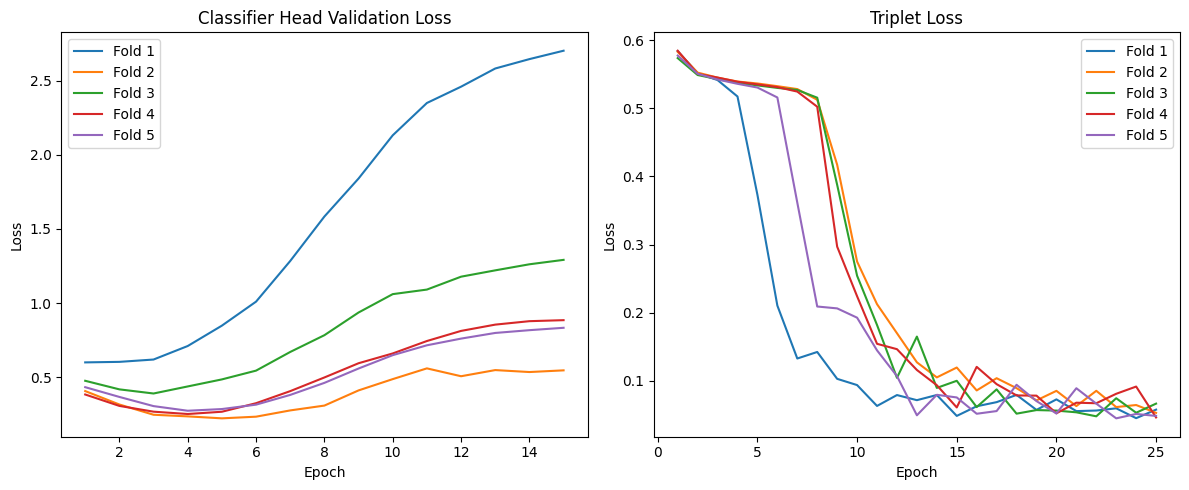

In [ ]:
plot_convergence(histories, triplet_epochs)

In [ ]:
# --- Build final stacked arrays from per-fold lists ---
if len(all_true) == 0 or len(all_pred) == 0:
    raise ValueError("No predictions were appended to all_true/all_pred. Did you forget to append inside the CV loop?")

# Outside loop (rest of your original code)
print("\n Prediction Distributions for All Folds:")
for f, dist in debug_distributions.items():
    print(f"Fold {f+1}: Predicted {dist['predicted']}, True {dist['true']}")


 Prediction Distributions for All Folds:
Fold 1: Predicted {np.int64(1): 165, np.int64(0): 73}, True {np.int64(0): 112, np.int64(1): 126}
Fold 2: Predicted {np.int64(0): 126, np.int64(1): 112}, True {np.int64(0): 112, np.int64(1): 126}
Fold 3: Predicted {np.int64(0): 141, np.int64(1): 97}, True {np.int64(0): 112, np.int64(1): 126}
Fold 4: Predicted {np.int64(0): 83, np.int64(1): 141}, True {np.int64(0): 98, np.int64(1): 126}
Fold 5: Predicted {np.int64(0): 115, np.int64(1): 123}, True {np.int64(0): 112, np.int64(1): 126}


In [ ]:
y_true_all = np.hstack(all_true).astype(int)
y_pred_all = np.hstack(all_pred).astype(int)
print("Final stacked lengths:", y_true_all.shape, y_pred_all.shape)
subject_ids_all = np.hstack(all_subject_ids)
print(subject_ids_all.shape)  # should match labels_all

Final stacked lengths: (1176,) (1176,)
(1176,)


In [ ]:
# optional sanity check: lengths must match
if y_true_all.shape[0] != y_pred_all.shape[0]:
    raise ValueError(f"Length mismatch: y_true_all {y_true_all.shape[0]} vs y_pred_all {y_pred_all.shape[0]}")

In [ ]:
# Explicit labels keep order predictable (Healthy=0, Disorder=1)
labels = [0, 1]

In [ ]:
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels)
precision_final = precision_score(y_true_all, y_pred_all, zero_division=0)
recall_final = recall_score(y_true_all, y_pred_all, zero_division=0)


In [ ]:
# Overall Results (unchanged)
print("\n Transformer Cross-Validation Metrics:")
print("Each fold accuracy:", transformer_accuracies)
print("Mean Accuracy: {:.4f}".format(np.mean(transformer_accuracies)))
print("Std Dev: {:.4f}".format(np.std(transformer_accuracies)))
print("Overall Precision: {:.4f}".format(precision_final))
print("Overall Recall: {:.4f}".format(recall_final))


 Transformer Cross-Validation Metrics:
Each fold accuracy: [0.7184873819351196, 0.924369752407074, 0.8529411554336548, 0.9151785969734192, 0.8865545988082886]
Mean Accuracy: 0.8595
Std Dev: 0.0748
Overall Precision: 0.8636
Overall Recall: 0.8746


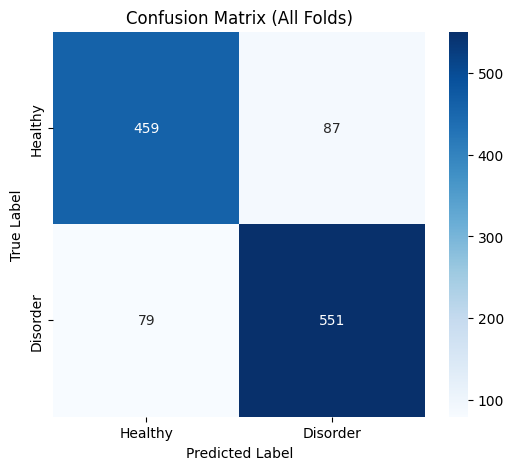

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Disorder'], yticklabels=['Healthy', 'Disorder'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (All Folds)')
# Save to file
# conf_matrix_path = os.path.join(confusion_matrix_dir, "confusion_matrix.png")
# plt.savefig(conf_matrix_path, dpi=300)
# print("Saved confusion matrix to:", conf_matrix_path)
plt.show()

In [ ]:
# ---------- Interactive t-SNE + static PNG + diagnostics ----------
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

# For interactive plot
try:
    import plotly.express as px
except Exception as e:
    raise ImportError("plotly is required for interactive t-SNE. Install with: pip install plotly") from e

tsne_dir = "/content/drive/MyDrive/MSU_EEG/Models/Small_CNN/Evaluation_Metrics/tsne_plots/with_Fewer_Epochs_on_Main_Classifier_Head"
os.makedirs(tsne_dir, exist_ok=True)

In [ ]:
# safety checks
if 'all_embeddings' not in globals() or len(all_embeddings) == 0:
    raise ValueError("all_embeddings is empty or missing. Ensure embeddings were appended inside the CV loop.")

if 'all_emb_labels' not in globals() or len(all_emb_labels) == 0:
    raise ValueError("all_emb_labels is empty or missing. Ensure labels were appended inside the CV loop.")


In [ ]:
# Stack embeddings and labels
embeddings_all = np.vstack(all_embeddings)   # (N, D)
labels_all = np.hstack(all_emb_labels)       # (N,)
labels_all = labels_all.astype(int)
N, D = embeddings_all.shape
print(f"t-SNE input shapes -> embeddings: {embeddings_all.shape} labels: {labels_all.shape}")

t-SNE input shapes -> embeddings: (1176, 64) labels: (1176,)


In [ ]:
# true and predicted arrays
y_true = labels_all.astype(int)
y_pred = y_pred_all.astype(int)

In [ ]:
# Create a string like "T0P0", "T0P1", etc.
combo = np.array([f"T{t}P{p}" for t, p in zip(y_true, y_pred)])

# Human-readable names for the legend
legend_names = {
    "T0P0": "True 0 / Pred 0",
    "T0P1": "True 0 / Pred 1",
    "T1P1": "True 1 / Pred 1",
    "T1P0": "True 1 / Pred 0"
}

color_map = {
    "T0P0": "green",   # correct healthy
    "T0P1": "blue",    # false positive
    "T1P1": "yellow",  # correct schizophrenic
    "T1P0": "red"      # false negative (most critical)
}

In [ ]:
# Attempt to assemble subject IDs:
# Preferred: user collected all_subject_ids in CV loop. If present, use it.
if 'all_subject_ids' in globals() and len(all_subject_ids) == len(all_emb_labels):
    subject_ids_all = np.hstack(all_subject_ids).astype(int)
    if subject_ids_all.shape[0] != N:
        print("Warning: all_subject_ids length mismatch; falling back to index-based IDs.")
        subject_ids_all = np.arange(N)
else:
    # fallback: if 'group_array' exists and its total equals original data length,
    # we cannot reliably map it to stacked embeddings without saved indices, so fallback to sequential IDs.
    print("Note: 'all_subject_ids' not found. Interactive hover will show sequential sample indices instead.")
    subject_ids_all = np.arange(N)   # simple fallback IDs

# Attempt to include predicted labels if available (all_pred)
if 'all_pred' in globals() and len(all_pred) > 0:
    try:
        y_pred_all = np.hstack(all_pred).astype(int)
        if y_pred_all.shape[0] != N:
            print("Warning: all_pred length mismatch; predictions will not be shown on hover.")
            y_pred_all = None
    except Exception:
        y_pred_all = None
else:
    y_pred_all = None

In [ ]:
# scale embeddings
X = StandardScaler().fit_transform(embeddings_all)

In [ ]:
# optional PCA if very high-D
if X.shape[1] > 50:
    pca = PCA(n_components=min(50, X.shape[1]), random_state=42)
    X_for_tsne = pca.fit_transform(X)
else:
    X_for_tsne = X

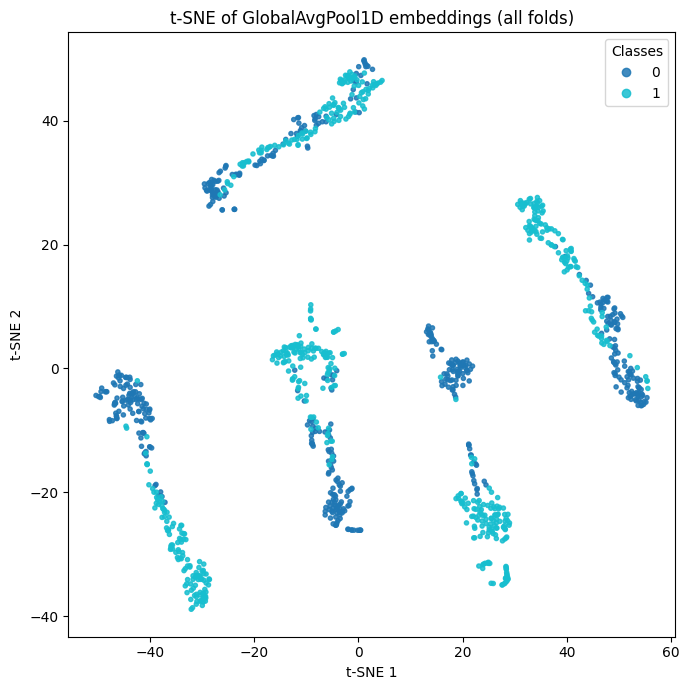

In [ ]:
# TSNE instantiation: work with different sklearn versions
import sklearn
ver_parts = sklearn.__version__.split('.')
major = int(ver_parts[0])
minor = int(ver_parts[1]) if len(ver_parts) > 1 else 0
tsne_kwargs = {'n_components': 2, 'perplexity': 30, 'learning_rate': 200, 'random_state': 42}
# sklearn >= 1.5 uses max_iter
if (major, minor) >= (1, 5):
    tsne_kwargs['max_iter'] = 1000
else:
    tsne_kwargs['n_iter'] = 1000

tsne = TSNE(**tsne_kwargs)
X2 = tsne.fit_transform(X_for_tsne)   # result (N,2)

# --- Save static PNG (matplotlib) ---
plt.figure(figsize=(7,7))
sc = plt.scatter(X2[:,0], X2[:,1], c=labels_all, cmap='tab10', s=9, alpha=0.85)
plt.legend(*sc.legend_elements(), title="Classes", loc='best')
plt.title("t-SNE of GlobalAvgPool1D embeddings (all folds)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
# static_out = os.path.join(tsne_dir, "tsne_all_val.png")
# plt.savefig(static_out, dpi=300)
plt.show()
# print("Saved static t-SNE PNG to:", static_out)

In [ ]:
# --- Interactive Plotly HTML ---
# Prepare hover data dictionary
hover_dict = {
    "index": np.arange(N),
    "true_label": y_true,
    "pred_label": y_pred,
    "subject_id": subject_ids_all.astype(int),
    "category": combo
}
if y_pred_all is not None:
    hover_dict["pred_label"] = y_pred_all.astype(int)

# Build px.scatter; use webgl rendering for speed with many points
fig = px.scatter(
    x=X2[:,0],
    y=X2[:,1],
    color=combo,
    color_discrete_map=color_map,
    hover_name=None,
    hover_data=hover_dict,
    title="Interactive t-SNE (4 Color: True vs Pred)",
    render_mode="webgl"
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(xaxis_title="t-SNE 1", yaxis_title="t-SNE 2", legend_title="True/Pred Class", legend=dict(itemsizing="constant"))

out_html = os.path.join(tsne_dir, "tsne_interactive_4color.html")
fig.write_html(out_html, include_plotlyjs="cdn")
print(f"Saved 4-color interactive t-SNE to: {out_html}")


Saved 4-color interactive t-SNE to: /content/drive/MyDrive/MSU_EEG/Models/Small_CNN/Evaluation_Metrics/tsne_plots/with_Fewer_Epochs_on_Main_Classifier_Head/tsne_interactive_4color.html


In [ ]:
# --- Quantitative checks ---
if len(np.unique(labels_all)) > 1 and X2.shape[0] >= 10:
    sil = silhouette_score(X2, labels_all)
    print("Silhouette (2D t-SNE):", round(sil, 4))

    knn = KNeighborsClassifier(n_neighbors=5)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs = cross_val_score(knn, X2, labels_all, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"kNN (2D t-SNE) 5fold mean acc: {accs.mean():.4f}, {accs.std():.4f}")

print("Interactive plot ready. To view: (1) download the HTML via scp or (2) serve the directory with `python3 -m http.server` and open the HTML in your browser.")
# -------------------------------------------------------------------------------


Silhouette (2D t-SNE): 0.0263
kNN (2D t-SNE) 5fold mean acc: 0.9073, 0.0273
Interactive plot ready. To view: (1) download the HTML via scp or (2) serve the directory with `python3 -m http.server` and open the HTML in your browser.


In [ ]:
# ======= Compare classifiers on embeddings (run after embeddings_all, labels_all, X2 exist) =======
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# ensure vars exist
assert 'embeddings_all' in globals(), "embeddings_all missing"
assert 'labels_all' in globals(), "labels_all missing"
N, D = embeddings_all.shape
y = labels_all.astype(int)

cv = GroupKFold(n_splits=5, shuffle=True, random_state=42)
groups = np.hstack(all_subject_ids)   # or use group_array if it matches embeddings_all

In [ ]:
def cv_scores_and_report(clf, X, y, cv):
    scores = cross_val_score(clf, X, y, cv=cv, groups=groups, scoring='accuracy', n_jobs=-1)
    y_pred = cross_val_predict(clf, X, y, cv=cv, groups=groups, n_jobs=-1)
    cm = confusion_matrix(y, y_pred, labels=np.unique(y))
    return scores, cm, y_pred

print(f"=== k-NN on {D}-D embeddings ===")
knn16 = KNeighborsClassifier(n_neighbors=5)
scores16, cm16, ypred16 = cv_scores_and_report(knn16, embeddings_all, y, cv)
print(f"k-NN {D}D acc mean/std:", scores16.mean(), scores16.std())
print("Confusion matrix (k-NN {D}D):\n", cm16)
print(classification_report(y, ypred16, digits=4))

=== k-NN on 64-D embeddings ===
k-NN 64D acc mean/std: 0.8714285714285713 0.03491189592914454
Confusion matrix (k-NN {D}D):
 [[460  86]
 [ 66 564]]
              precision    recall  f1-score   support

           0     0.8745    0.8425    0.8582       546
           1     0.8677    0.8952    0.8812       630

    accuracy                         0.8707      1176
   macro avg     0.8711    0.8689    0.8697      1176
weighted avg     0.8709    0.8707    0.8706      1176



In [ ]:
# If you have X2 (2-D t-SNE), compare
if 'X2' in globals():
    print("\n=== k-NN on 2-D t-SNE ===")
    knn2 = KNeighborsClassifier(n_neighbors=5)
    scores2, cm2, ypred2 = cv_scores_and_report(knn2, X2, y, cv)
    print("k-NN 2D acc mean/std:", scores2.mean(), scores2.std())
    print("Confusion matrix (k-NN 2D):\n", cm2)
    print(classification_report(y, ypred2, digits=4))

# Logistic regression on embeddings (linear separability test)
print(f"\n=== Logistic Regression ({D}-D embeddings) ===")
logreg = LogisticRegression(max_iter=2000, solver='saga')  # works well for larger data
scores_log, cm_log, ypred_log = cv_scores_and_report(logreg, embeddings_all, y, cv)
print(f"Logistic acc mean/std:", scores_log.mean(), scores_log.std())
print("Confusion matrix (LogReg {D}D):\n", cm_log)
print(classification_report(y, ypred_log, digits=4))


=== k-NN on 2-D t-SNE ===
k-NN 2D acc mean/std: 0.8664390756302522 0.05658333722902645
Confusion matrix (k-NN 2D):
 [[455  91]
 [ 67 563]]
              precision    recall  f1-score   support

           0     0.8716    0.8333    0.8521       546
           1     0.8609    0.8937    0.8769       630

    accuracy                         0.8656      1176
   macro avg     0.8663    0.8635    0.8645      1176
weighted avg     0.8659    0.8656    0.8654      1176


=== Logistic Regression (64-D embeddings) ===
Logistic acc mean/std: 0.8616071428571429 0.049544323027093405
Confusion matrix (LogReg {D}D):
 [[456  90]
 [ 74 556]]
              precision    recall  f1-score   support

           0     0.8604    0.8352    0.8476       546
           1     0.8607    0.8825    0.8715       630

    accuracy                         0.8605      1176
   macro avg     0.8605    0.8589    0.8595      1176
weighted avg     0.8605    0.8605    0.8604      1176



In [ ]:
# Quick summary table
print("\nSummary (mean accuracies):")
print(f"CNN (your reported mean): {np.mean(transformer_accuracies):.4f}")
print(f"k-NN on {D}-D: {scores16.mean():.4f}")
if 'scores2' in locals():
    print(f"k-NN on 2-D t-SNE: {scores2.mean():.4f}")
print(f"Logistic on {D}-D: {scores_log.mean():.4f}")
# =================================================================================================


Summary (mean accuracies):
CNN (your reported mean): 0.8595
k-NN on 64-D: 0.8714
k-NN on 2-D t-SNE: 0.8664
Logistic on 64-D: 0.8616
